## Units, conventions, and overview

We work in geometric units $G=c=1$ and set $M\equiv 1$ unless stated. Coordinates are Boyer–Lindquist $(t,r,\theta,\phi)$. The observer is at large radius $r_0$ with viewing angle $\theta_0$. Screen coordinates $(b,\alpha)$ follow Bardeen’s mapping.

Goal of this notebook: ray-trace null geodesics, accumulate **invariant** emissivity from a BLR-like disk, and build an **energy-resolved spectrum** including **Gaussian (turbulent) Doppler broadening** as specified in the paper.


In [1]:
import sympy as sp
import jax
import jax.numpy as jnp
import numpy as np
import diffrax
import matplotlib.pyplot as plt
from functools import partial


We use the Kerr metric in Boyer–Lindquist coordinates with
$$
\Sigma=r^2+a^2\cos^2\theta,\qquad
\Delta=r^2-2Mr+a^2.
$$
The non-zero components $g_{\mu\nu}$ in $(t,r,\theta,\phi)$ match the paper.  
Null geodesics follow from the Hamiltonian
$$
H=\tfrac12\Big(
\frac{p_r^2}{g_{rr}}+\frac{p_\theta^2}{g_{\theta\theta}}
- \frac{L^2 g_{tt}+2EL\,g_{t\phi}+E^2 g_{\phi\phi}}{D}
\Big)=0,\qquad D=g_{t\phi}^2-g_{tt}\,g_{\phi\phi}.
$$
We obtain the first-order system via Hamilton’s equations $\dot{x}^\mu=\partial H/\partial p_\mu$, $\dot{p}_\mu=-\partial H/\partial x^\mu$.


In [2]:
m, a = sp.symbols('m a')
r, th = sp.symbols('r th')
pt, pr, pth, pphi = sp.symbols('pt pr pth pphi')


Sigma = r**2 + a**2 * sp.cos(th)**2
Delta = r**2 - 2*m*r + a**2

g_tt = -(1 - (2*m*r)/Sigma)
g_rr = Sigma / Delta
g_thth = Sigma
g_phiphi = ( (r**2 + a**2 + (2*m*a**2*r*sp.sin(th)**2)/Sigma) * sp.sin(th)**2 )
g_tphi = -(2*m*a*r*sp.sin(th)**2)/Sigma


D = g_tphi**2 - g_tt * g_phiphi


E = -pt
L = pphi
H = (1/2) * (
    pr**2 / g_rr
    + pth**2 / g_thth
    - (L**2 * g_tt + 2*E*L * g_tphi + E**2 * g_phiphi) / D
)


tdot = sp.diff(H, pt)
rdot = sp.diff(H, pr)
thdot = sp.diff(H, pth)
phidot = sp.diff(H, pphi)
prdot = -sp.diff(H, r)
pthdot = -sp.diff(H, th)

## Equations of motion (EOM)

The EOM $(\dot t,\dot r,\dot\theta,\dot\phi,\dot p_r,\dot p_\theta)$ are produced symbolically and JIT-compiled for speed. We integrate with `diffrax` using an adaptive controller and terminate at the horizon $r_+=M+\sqrt{M^2-a^2}$ (with a small buffer $+\varepsilon$).


In [3]:
modules = ["jax", {"sqrt": jnp.sqrt, "sin": jnp.sin, "cos": jnp.cos}]

tdot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), tdot, modules=modules)
rdot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), rdot, modules=modules)
thdot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), thdot, modules=modules)
phidot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), phidot, modules=modules)
prdot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), prdot, modules=modules)
pthdot_func = sp.lambdify((r, th, pt, pphi, pr, pth, m, a), pthdot, modules=modules)

## Screen-to-momenta mapping at the observer

At large $r_0$, the Bardeen screen coordinates map to constants of motion
$$
E=1,\qquad p_t=-E,\qquad p_\phi=-\,b\,E\sin\theta_0
$$
and $p_r$ is set by the null constraint. This ensures that each pixel $(b,\alpha)$ launches one null ray inward with the desired impact parameters.


In [4]:
@jax.jit
def initial_vector_batch(r0, th0, b_list, al_list, metric_params, E=1.0, inward=True):
    batch_size = b_list.shape[0]
    counts0 = jnp.zeros((batch_size, num_bins))
    
    t0 = jnp.zeros(batch_size)
    L_list = -b_list * E * jnp.sin(th0) 
    vth0_list = al_list / (r0 ** 2)
    m_val = metric_params['m']
    a_val = metric_params['a']
    
    Σ = r0**2 + a_val**2 * jnp.cos(th0)**2
    Δ = r0**2 - 2*m_val*r0 + a_val**2

    g_tt_val    = -(1.0 - (2.0*m_val*r0)/Σ)
    g_tphi_val  = - (2.0*m_val*a_val*r0/Σ) * jnp.sin(th0)**2
    g_phiphi_val = (r0**2 + a_val**2 + (2.0*m_val*a_val**2*r0*jnp.sin(th0)**2)/Σ) * jnp.sin(th0)**2
    g_rr_val    = Σ / Δ
    g_thth_val  = Σ
    D_val = g_tphi_val**2 - g_tt_val * g_phiphi_val

    E_val = E
    L_val = L_list

    vt0 = (E_val * g_phiphi_val + L_val * g_tphi_val) / D_val
    vth0_sq = vth0_list ** 2
    numerator = (
        (L_val ** 2 * g_tt_val + 2 * E_val * L_val * g_tphi_val +
         E_val ** 2 * g_phiphi_val) / D_val
        - vth0_sq * g_thth_val
    )
    vr0_sq = numerator / g_rr_val
    vr0 = jnp.sqrt(jnp.abs(vr0_sq))
    vr0 = jnp.where(inward, -vr0, vr0)
    pr0 = g_rr_val * vr0
    pth0 = g_thth_val * vth0_list
    pt0 = -E_val * jnp.ones(batch_size)
    pphi0 = L_val
    φ0 = jnp.zeros(batch_size)

    I0 = jnp.zeros(batch_size)  
    ###
    winding0 = jnp.zeros(batch_size)
    ####
    batch_size = b_list.shape[0]
    counts0 = jnp.zeros((batch_size, num_bins),dtype=jnp.float64) 
    inside_disk_counter0 = jnp.zeros(batch_size)

    y0 = jnp.concatenate([
        t0[:, None],
        (r0 * jnp.ones(batch_size))[:, None],
        (th0 * jnp.ones(batch_size))[:, None],
        φ0[:, None],
        pr0[:, None],
        pth0[:, None],
        pt0[:, None],
        pphi0[:, None],
        winding0[:,None],
        counts0
    ], axis=1)
    return y0

## Fluid rotation (emitter 4-velocity)

We assume Keplerian rotation:
$$
\Omega=\frac{\sqrt{M}}{(r\sin\theta)^{3/2}+a\sqrt{M}},
$$
with $u^\mu=(u^t,0,0,\Omega\,u^t)$ normalized by $g_{\mu\nu}u^\mu u^\nu=-1$.  
This sets the emitter rest frame used for the redshift $E_{\rm obs} = -1/(k_\mu u^\mu)$.


In [5]:
@jax.jit
def calculate_azimuthal_velocity(r, theta, a_value, m_value):
    omega=(jnp.sqrt(m_value)/((r*jnp.sin(theta))**(3/2)+a_value*jnp.sqrt(m_value))) 
    
    vphi_fluid = omega
    return vphi_fluid

## BLR geometry and emissivity

We model an axisymmetric, optically thin BLR-like disk:
- Cylindrical annulus $500M<\varpi<1000M$ with vertical extent $|z|<15M$.
- Two emissivity options used in the paper:
  1. Exponential in radius with vertical $e^{-|z|/H(r)}$.
  2. Power-law $j_0\propto (r/R_{\rm in})^{-p}$ with the same vertical factor.

In both cases we use $H(r)=\alpha\,r$ and $\alpha=0.1$, so $e^{-|z|/H}=e^{-\kappa|\cos\theta|}$ with $\kappa=1/\alpha=10$.


In [6]:
@jax.jit
def density_BLR_3d(r, theta, phi):


    R_in  = 500.0
    R_out = 1000.0
    

    rho0       = 1.0       
    r_scale    = 2000.0    
    

    alpha      = 0.1       
    

    z = r * jnp.cos(theta)
    

    radial_factor = rho0 * jnp.exp(-(r - R_in) / r_scale)
    

    H_r = alpha * r
    vertical_factor = jnp.exp(-jnp.abs(z) / H_r)
    

    density_3d = radial_factor * vertical_factor
    density_3d = jnp.where((r >= R_in) & (r <= R_out), density_3d, 0.0)
    
    return density_3d

@jax.jit
def density_BLR_3d_powerlaw(r, θ, φ):
    R_in, R_out = 500.0, 1000.0
    ρ0 = 1.0
    p   = 2.5   
    α   = 0.1


    z = r * jnp.cos(θ)


    radial_factor = ρ0 * jnp.where(r > R_in,
                                    (r / R_in) ** (-p),
                                    0.0)


    H_r = α * r
    vertical_factor = jnp.exp(-jnp.abs(z) / H_r)

    ρ = radial_factor * vertical_factor

    ρ = jnp.where((r >= R_in) & (r <= R_out), ρ, 0.0)
    return ρ

@jax.jit
def doppler_width_from_u_th_and_mass(E0, u_th_km_s, m_a):

    c_km_s = 299792.458
    vth_dimless = u_th_km_s / c_km_s
    k_B_eV_per_K = 8.617333262145e-5
    delta_E = E0 * vth_dimless

    return delta_E


@jax.jit
def doppler_profile(nu, nu0, delta_nu_D):
    return (1 / (delta_nu_D * jnp.sqrt(jnp.pi))) * jnp.exp(-((nu - nu0) ** 2) / (delta_nu_D ** 2))

@jax.jit
def disk_intersection(y):
    r, θ, φ = y[1], y[2], y[3]

    sinθ, cosθ = jnp.sin(θ), jnp.cos(θ)
    x   = r * sinθ * jnp.cos(φ)
    y_  = r * sinθ * jnp.sin(φ)
    z   = r * cosθ
    ρ   = jnp.sqrt(x**2 + y_**2)

    in_rho = (ρ > 500.0) & (ρ < 1000.0)
    in_z   = (z > -15.0) & (z < 15.0)

    behind = x < 0.0

        # ∈ (‑π, π]
    φ_wrapped = jnp.mod(φ, 2.0 * jnp.pi)        # [0, 2π)
    dφ = jnp.mod(φ_wrapped - jnp.pi + jnp.pi, 2.0 * jnp.pi) - jnp.pi

    Δφ = 30.0 / ρ 
    in_wedge = jnp.abs(dφ) < 0.5 * Δφ

    return in_rho & in_z #& behind & in_wedge

## Energy grid and binning fidelity

We use an **energy** histogram $[E_{\min},E_{\max}]$ with `num_bins` bins.  
Doppler broadening is applied by integrating the **Gaussian CDF** over each bin interval.  
Choose $[E_{\min},E_{\max}]$ wide enough to contain both peaks and their wings (e.g., a symmetric window around $E_0$); the overall normalization is arbitrary unless absolute fluxes are required.


In [8]:
E_min = 0.995
E_max = 1.000
num_bins = 150
bin_edges = jnp.linspace(E_min, E_max, num_bins + 1,dtype=jnp.float64)
metric_params = {'m': 1.0, 'a': 0.0}
E0 = 1.0  
args_array = jnp.array([metric_params['m'], metric_params['a'], E0])

## Invariant transfer and line model

Radiative transfer uses the Lorentz-invariant form along null rays:
$$
dI_E \propto \gamma^2\, j_0 \, d\lambda,\qquad \gamma=\frac{E_{\rm obs}}{E_0}.
$$
The line is **Gaussian** in the emitter frame with turbulent width
$$
\sigma \;=\; 5\times 10^{-4}\,E_0 \;\;\simeq\;\; \frac{150~{\rm km\,s^{-1}}}{c}\,E_0.
$$



In [10]:
@partial(jax.jit, static_argnames=("num_bins",))
def intensity_at_point(points_4_velocity, E0, a_value, m_value, bin_edges, bin_width, E_min, num_bins):
    λ, t, r, theta, phi, vt, vr, vtheta, vphi = points_4_velocity
    density=  density_BLR_3d_powerlaw(r,theta,phi)

    z = r * jnp.cos(theta)

    Σ = r**2 + a_value**2 * jnp.cos(theta)**2
    Δ = r**2 - 2.0*m_value*r + a_value**2

    g = jnp.array([
        [-(1.0 - (2.0*m_value*r)/Σ),                           0.0,       0.0,   -(2.0*m_value*a_value*r/Σ)*jnp.sin(theta)**2],
        [0.0,                                                  Σ/Δ,       0.0,    0.0],
        [0.0,                                                  0.0,       Σ,      0.0],
        [-(2.0*m_value*a_value*r/Σ)*jnp.sin(theta)**2,         0.0,       0.0,   (r**2 + a_value**2 + (2.0*m_value*a_value**2*r*jnp.sin(theta)**2)/Σ)*jnp.sin(theta)**2]
    ])
    
    k_0 = jnp.dot(g, jnp.array([vt, vr, vtheta, vphi]))

    vphi_fluid = calculate_azimuthal_velocity(r, theta, a_value, m_value)
    u_0_candidate = jnp.array([1.0, 0.0, 0.0, vphi_fluid])
    dot_product = jnp.dot(u_0_candidate, jnp.dot(g, u_0_candidate))
    vt_fluid = jnp.sqrt(-1.0 / dot_product)
    vphi_fluid = vphi_fluid * vt_fluid
    u_0 = jnp.array([vt_fluid, 0.0, 0.0, vphi_fluid])

    k_0_u_0 = jnp.dot(k_0, u_0)
    E_obs = -1.0 / k_0_u_0
    
    E_obs=jnp.clip(E_obs, E_min, E_max)
    
    gamma_inv = 1.0 / E_obs
    j0 = density
    intensity = gamma_inv * (j0 / E0**3) * (E_obs**3)
    
#Implementation notes.**  
#- Use $I_E \propto \gamma^2 j_0$ (no extra powers of $E_0$).  
#- Do **not** clip $E_{\rm obs}$ before binning; the CDF integration plus index bounds already enforce $[E_{\min},E_{\max}]$.  
#- The Gaussian CDF is evaluated over each bin $[E_{\rm low},E_{\rm high}]$ to deposit the correct probability mass; 
    #this avoids bin-center approximations.
    def safe_binning(_):
        u_th_km_s = 150.0
        m_a_val = 938.27208816e6
        delta_nu_D = doppler_width_from_u_th_and_mass(E0, u_th_km_s, m_a_val)
        sqrt2 = jnp.sqrt(2.0)
        central_float = (E_obs - E_min) / bin_width
        central_idx = jnp.floor(central_float).astype(jnp.int32)
        offsets = jnp.arange(-3, 4)
        bin_indices = central_idx + offsets
        bin_lows = E_min + bin_indices * bin_width
        bin_highs = bin_lows + bin_width

        cdf_low = 0.5 * (1.0 + jax.scipy.special.erf((bin_lows - E_obs) / (delta_nu_D * sqrt2)))
        cdf_high = 0.5 * (1.0 + jax.scipy.special.erf((bin_highs - E_obs) / (delta_nu_D * sqrt2)))
        contributions = (cdf_high - cdf_low) * intensity

        valid_mask = (bin_indices >= 0) & (bin_indices < num_bins)
        contributions = jnp.where(valid_mask, contributions, 0.0)

        def update_contribution(i, total):
            return total.at[bin_indices[i]].add(contributions[i])
        total_contrib = jax.lax.fori_loop(0, offsets.shape[0], update_contribution, jnp.zeros(num_bins, dtype=jnp.float64))
        return total_contrib


    condition = jnp.logical_or(jnp.isnan(intensity), jnp.isnan(E_obs))
    contributions_out = jax.lax.cond(
        condition,
        lambda _: jnp.zeros(num_bins, dtype=jnp.float64),
        safe_binning,
        operand=None
    )
    return contributions_out

def make_eom_system(bin_edges, E_min, E_max, num_bins):  # Add num_bins as argument
    bin_width = (E_max - E_min) / num_bins
    @jax.jit
    def eom_system(t, y, args):
        m_val = args[0]
        a_val = args[1]
        E0 = args[2]


        t_var = y[0]
        r_val = y[1]
        th_val = y[2]
        phi_val = y[3]
        pr_val = y[4]
        pth_val = y[5]
        pt_val = y[6]
        pphi_val = y[7]
        winding=y[8]
        counts = y[9:]

        dt_dλ = tdot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val)
        dr_dλ = rdot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val)
        dth_dλ = thdot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val)
        dphi_dλ = phidot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val,)
        dpr_dλ = prdot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val)
        dpth_dλ = pthdot_func(r_val, th_val, pt_val, pphi_val, pr_val, pth_val, m_val, a_val)
        dpt_dλ = 0.0
        dpphi_dλ = 0.0 


        vt = dt_dλ
        vr = dr_dλ
        vtheta = dth_dλ
        vphi = dphi_dλ

        points_4_velocity = [t, t_var, r_val, th_val, phi_val, dt_dλ, dr_dλ, dth_dλ, dphi_dλ]
        is_inside_disk = disk_intersection(y)

        def update_intensity_and_counts(_):
            contributions = intensity_at_point(
                points_4_velocity, E0, a_val, m_val, 
                bin_edges, bin_width, E_min, num_bins  
            )
            return jnp.sum(contributions), contributions

        def no_update(_):
            return 0.0, jnp.zeros_like(counts)


        intensity_increment, counts_increment = jax.lax.cond(
            is_inside_disk,
            update_intensity_and_counts,
            no_update,
            operand=None
        )

        r_thresh = 20.0  

        dtotal_angle_dλ = jnp.where(
            r_val < r_thresh,
            jnp.sqrt(dth_dλ**2 + (jnp.sin(th_val)*dphi_dλ)**2),
            0.0
        )

        
        dy_dt = jnp.concatenate([
            jnp.array([dt_dλ, dr_dλ, dth_dλ, dphi_dλ, dpr_dλ, dpth_dλ, dpt_dλ, dpphi_dλ,dtotal_angle_dλ]),
            counts_increment
        ])
        return dy_dt

    return eom_system

eom_system = make_eom_system(bin_edges, E_min, E_max, num_bins)
ode_term = diffrax.ODETerm(eom_system)
t0 = 0.0
t1 = 15000.0
dt0 = 0.025
r0 = 10000.0
th0 = (80.0*jnp.pi / 2)/90  
E = 1.0
inward = True
jax.config.update("jax_enable_x64", True)
E0 = 1.0  
args_array = jnp.array([
    metric_params['m'],
    metric_params['a'],
    E0
], dtype=jnp.float64)  
controller = diffrax.PIDController(rtol=1e-10, atol=1e-11,dtmin=0.01, force_dtmin=True)  

## Termination condition

We stop integration at the outer horizon
$$
r_+=M+\sqrt{M^2-a^2},
$$
using a small positive offset $+\varepsilon$ to avoid numerical singularities. Rays that cross the BLR volume contribute to the spectrum; others are discarded.


In [11]:
def solve_single_trajectory(y0, args, ode_term, solver):
    def event_function(t, y, args):

        r_val = y[1]  
        m_val, a_val, E0 = args
        epsilon = 0.01
        condition_r = r_val - (1.0+jnp.sqrt(-a_val**2 +1.0)+ epsilon)
        return condition_r

    def event_function_wrapper(t, y, args, **kwargs):
        return event_function(t, y, args)

    event = diffrax.Event(cond_fn=event_function_wrapper)

    solution = diffrax.diffeqsolve(
        terms=ode_term,
        solver=solver,
        t0=t0,
        t1=t1,
        dt0=dt0,
        y0=y0,
        args=args,
        max_steps=1500000,
        event=event,
        stepsize_controller=controller,
        saveat=diffrax.SaveAt(t1=True)
    )
    final_state = solution.ys[-1]
    final_time = solution.ts[-1]
    final_winding = final_state[8]
    final_counts = final_state[9:]

    return final_state[:8], final_counts, final_winding

solver = diffrax.Tsit5()


solve_trajectories = jax.vmap( 
    solve_single_trajectory,
    in_axes=(0, 0, None, None))

## Screen sampling and resolution

We sample a uniform grid in $(b,\alpha)$.  
- Choose ranges to capture the full Einstein ring and inner image.  
- For spectra, ensure the screen covers the bright arcs responsible for the central double peak near $E/E_0\simeq 1$.


In [12]:
from tqdm import tqdm  
import pickle

resolution_x = 150
resolution_y = 150
b_values = jnp.linspace(-15.0, 15.0, resolution_x)
al_values = jnp.linspace(-6.0, 25.0, resolution_y)
b_grid, al_grid = jnp.meshgrid(b_values, al_values, indexing='ij')
b_list_full = b_grid.ravel()
al_list_full = al_grid.ravel()
b_list_filtered=b_list_full
al_list_filtered=al_list_full
batch_size = 10000
num_rays = b_list_filtered.shape[0]
num_batches = (num_rays + batch_size - 1) // batch_size 


global_counts = jnp.zeros(num_bins)

import numpy as np
from tqdm import tqdm
import jax.numpy as jnp


global_counts_dict = {}

with tqdm(total=num_batches, desc="Processing Batches") as pbar:
    for batch_idx in range(num_batches):
        start = batch_idx * batch_size
        end = min(start + batch_size, num_rays)
        b_batch = b_list_filtered[start:end]
        al_batch = al_list_filtered[start:end]
        

        y0s_batch = initial_vector_batch(r0, th0, b_batch, al_batch, metric_params, E=E, inward=inward)
        argss_batch = jnp.tile(args_array, (b_batch.shape[0], 1))
        

        final_results_batch = solve_trajectories(y0s_batch, 
                                                 argss_batch, ode_term, solver)
        final_state_batch, final_counts_batch, final_winding_batch = final_results_batch
        

        orders_batch = jnp.floor(jnp.abs(final_winding_batch) / (2 * jnp.pi)).astype(jnp.int32)
        

        unique_orders = jnp.unique(orders_batch)
        for order in unique_orders:
            mask_order = orders_batch == order
            counts_order = jnp.sum(final_counts_batch[mask_order, :], axis=0)
            if int(order) in global_counts_dict:
                global_counts_dict[int(order)] += counts_order
            else:
                global_counts_dict[int(order)] = counts_order
        
        pbar.update(1)

global_counts_dict = {order: np.array(counts) for order, counts in global_counts_dict.items()}

Processing Batches: 100%|█████████████████████████| 3/3 [01:24<00:00, 28.26s/it]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

counts_sum = None
for order, arr in global_counts_dict.items():
    a = np.asarray(arr, dtype=float)
    counts_sum = a if counts_sum is None else (counts_sum + a)
edges   = np.linspace(float(E_min), float(E_max), int(num_bins) + 1)
centers = 0.5 * (edges[:-1] + edges[1:])
dE      = edges[1] - edges[0]
BMIN, BMAX = float(b_values.min()), float(b_values.max())
AMIN, AMAX = float(al_values.min()), float(al_values.max())
sinth      = float(jnp.sin(th0))
N_eff = int(b_list_filtered.size)
area_screen = ((BMAX - BMIN) / sinth) * (AMAX - AMIN)
weight = (area_screen / float(N_eff)) / dE
F = counts_sum * weight

# 5) Plot
fig, ax = plt.subplots(figsize=(7.8, 5.0), dpi=180)
ax.plot(centers, F, lw=1.8)
ax.set_xlim(float(E_min), float(E_max))
ax.set_xlabel(r"$E/E_0$")
ax.set_ylabel(r"$F(E)$")
ax.grid(True, lw=0.3, alpha=0.45)

# nicer y-axis (start at 0 with small headroom)
ymax = float(np.nanmax(F)) if F.size else 1.0
ax.set_ylim(0.0, ymax*1.05)

plt.tight_layout()
plt.show()


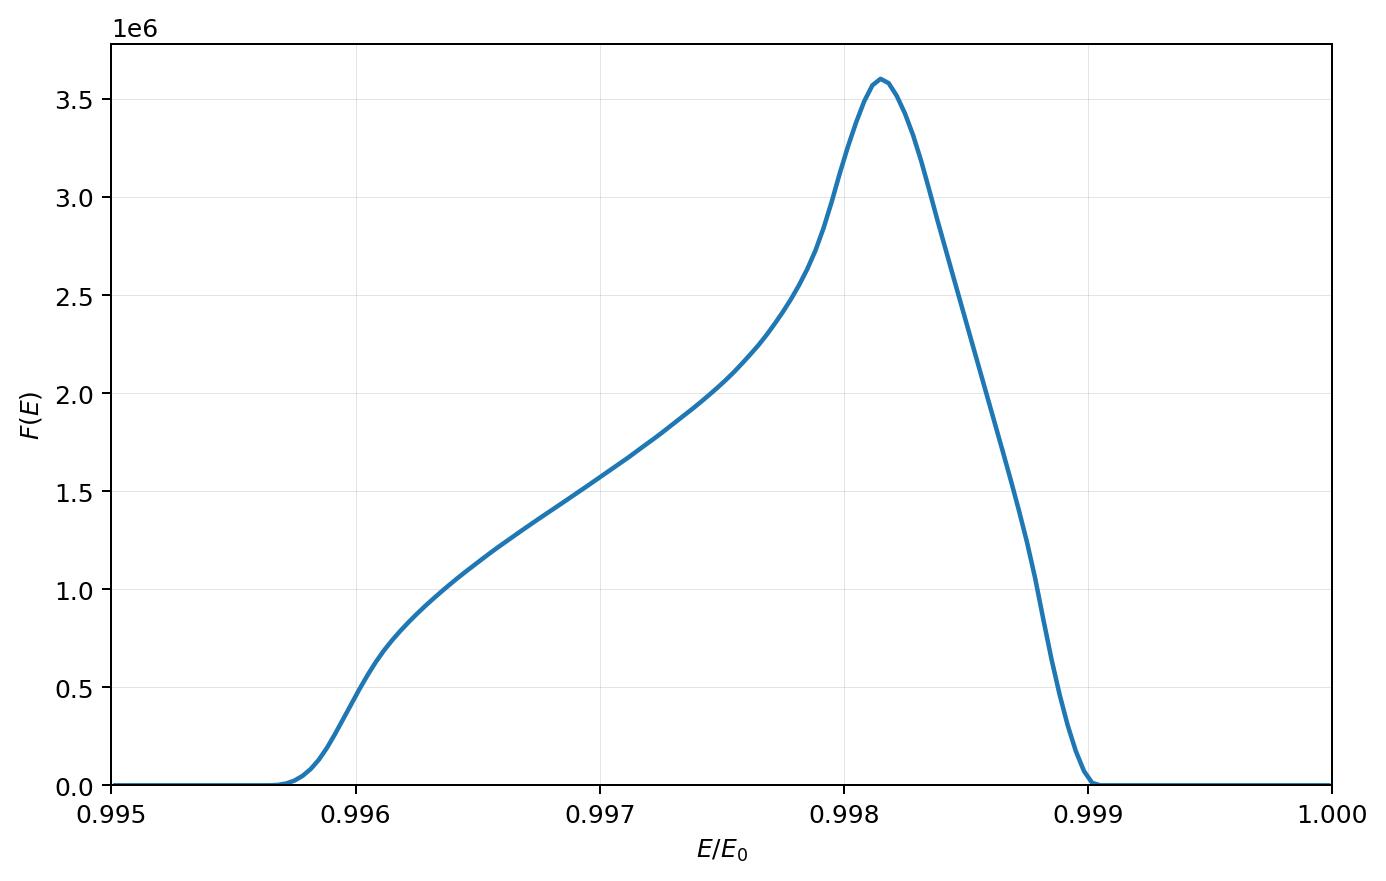

In [13]:

import numpy as np
import matplotlib.pyplot as plt
counts_sum = None
for order, arr in global_counts_dict.items():
    a = np.asarray(arr, dtype=float)
    counts_sum = a if counts_sum is None else (counts_sum + a)

edges   = np.linspace(float(E_min), float(E_max), int(num_bins) + 1)
centers = 0.5 * (edges[:-1] + edges[1:])
dE      = edges[1] - edges[0]

BMIN, BMAX = float(b_values.min()), float(b_values.max())
AMIN, AMAX = float(al_values.min()), float(al_values.max())
sinth      = float(jnp.sin(th0))


N_eff = int(b_list_filtered.size)
area_screen = ((BMAX - BMIN) / sinth) * (AMAX - AMIN)
weight = (area_screen / float(N_eff)) / dE
F = counts_sum * weight

fig, ax = plt.subplots(figsize=(7.8, 5.0), dpi=180)
ax.plot(centers, F, lw=1.8)
ax.set_xlim(float(E_min), float(E_max))
ax.set_xlabel(r"$E/E_0$")
ax.set_ylabel(r"$F(E)$")
ax.grid(True, lw=0.3, alpha=0.45)

# nicer y-axis (start at 0 with small headroom)
ymax = float(np.nanmax(F)) if F.size else 1.0
ax.set_ylim(0.0, ymax*1.05)

plt.tight_layout()
plt.show()
